# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
# MY CODE START FROM HERE:

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

# convert BGR to HSV, then convert to gray only based on the third channel of HSV
# This method can well detect both white and yellow lane markings
def grayscaleHSV(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsvv = np.zeros_like(hsv)
    hsvv[:,:,0]=hsv[:,:,2]
    hsvv[:,:,1]=hsv[:,:,2]
    hsvv[:,:,2]=hsv[:,:,2]
    
    return cv2.cvtColor(hsvv, cv2.COLOR_BGR2GRAY)

# Filter the gray scale image based on intensity. Isolate lane markings as much as possible
def intensityfilter(gray,threshold):
    
    threshold = np.max(gray)*threshold
    thresholds = (gray < threshold) 
    filtered = np.copy(gray)
    filtered[thresholds] = threshold
    return filtered

def grayscale(img):
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# when detecting lane in videos, keep tracking detections from last 3 frames, 
# linearly combine the detection from the current frame and the average of detections from last 3 frames
# This method smooth the detection through the video and add more robustness to noise.
def movingAverage(recentlist, new_sample,memory=3, N=5):
    
    if (len(recentlist) == 0):
        recentlist.append(new_sample)
        return new_sample
    
    movingaverage = np.mean(recentlist,0)
    
    avg = ((N-1)*movingaverage + new_sample)/N
    
    recentlist.append(tuple(avg))
    if (len(recentlist) > memory):
        del recentlist[0]

    return avg;
                

# def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
#     if lines is None:
#         return
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# 1. Filter all detected lines by slope
# 2. group filtered lines by slope, find lines belong to left and right lane separately
# 3. fit a new line using all end points of lines grouped as left lane and right lane respectively
# 4. truncate the fitted lines 
# 5. movingaverage the truncated lines
# 6. draw final results
def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # define truncate location
    y_bottom=int(0.98*img.shape[0])
    y_top=int(0.6*img.shape[0])
    # define slope filter range
    right_slope_max=img.shape[0]*0.6/(img.shape[1]*0.4)
    right_slope_min=img.shape[0]*0.4/(img.shape[1]*0.6)
    left_slope_max=-img.shape[0]*0.4/(img.shape[1]*0.6)
    left_slope_min=-img.shape[0]*0.6/(img.shape[1]*0.4)
    # initial containers
    leftpoints = []
    rightpoints = []
    
    # filter and group by slope
    if lines is None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            if right_slope_max>=slope>=right_slope_min:
                rightpoints.append([x1,y1])
                rightpoints.append([x2,y2])
                
                
            if left_slope_max>=slope>=left_slope_min:
                leftpoints.append([x1,y1])
                leftpoints.append([x2,y2])
    
    global Right_previous
    
    # if no lane detected in the current frame, use the detection from previous frames
    if len(rightpoints)==0:
        Right_current = tuple(np.mean(Right_previous,0))
    
    # if lane detected
    if len(rightpoints)>0:
        r_vx,r_vy,r_cx,r_cy = cv2.fitLine(np.array(rightpoints), cv2.DIST_L2, 0, 0.01, 0.01)
        # truncate the line
        right_m=r_vy/r_vx
        right_b=r_cy-right_m*r_cx
        right_x_top = (y_top-right_b)/right_m
        right_x_bottom = (y_bottom-right_b)/right_m
        Right_current = (right_x_top, right_x_bottom)
    # movingaverage it and update the movingaverage    
    right_x_top,right_x_bottom = movingAverage(Right_previous, Right_current)
    # draw final result
    cv2.line(img, (int(right_x_top), y_top), (int(right_x_bottom), y_bottom), color, thickness)
    
    global Left_previous
    
    # if no lane detected in the current frame, use the detection from previous frames
    if len(leftpoints)==0:
        Left_current = tuple(np.mean(Left_previous,0))
    
    if len(leftpoints)>0:
        l_vx,l_vy,l_cx,l_cy = cv2.fitLine(np.array(leftpoints), cv2.DIST_L2, 0, 0.01, 0.01)
         # truncate the line
        left_m=l_vy/l_vx
        left_b=l_cy-left_m*l_cx
        left_x_top = (y_top-left_b)/left_m
        left_x_bottom = (y_bottom-left_b)/left_m
        Left_current = (left_x_top, left_x_bottom)
    # movingaverage it and update the movingaverage 
    left_x_top,left_x_bottom = movingAverage(Left_previous, Left_current)
    # draw final result
    cv2.line(img, (int(left_x_bottom), y_bottom), (int(left_x_top), y_top), color, thickness)
        
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:


def process_image(image):
    

    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray = grayscaleHSV(image)
    threshold = 0.7
    gray_filtered = intensityfilter(gray,threshold)
    kernel_size = 3
    blur_gray = gaussian_blur(gray_filtered, kernel_size)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.1,imshape[0]),(imshape[1]*0.42, imshape[0]*0.61), (imshape[1]*0.58, imshape[0]*0.61), (imshape[1]*0.92,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 250    # maximum gap in pixels between connectable line segments

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(line_image, image, α=0.8, β=1., λ=0.)

    return result

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
a=os.listdir("test_images/")

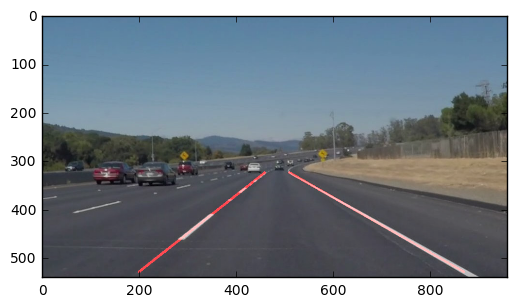

In [6]:
Left_previous = []
Right_previous = []
image = (mpimg.imread('test_images/'+a[0]))
result = process_image(image)
plt.imshow(result)

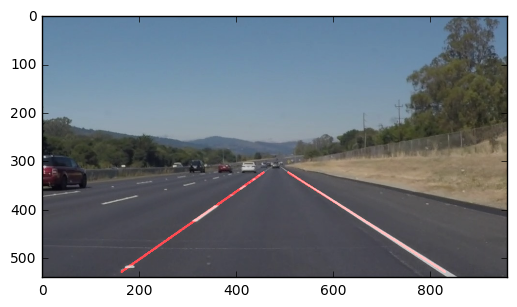

In [7]:
Left_previous = []
Right_previous = []
image = (mpimg.imread('test_images/'+a[1]))
result = process_image(image)
plt.imshow(result)

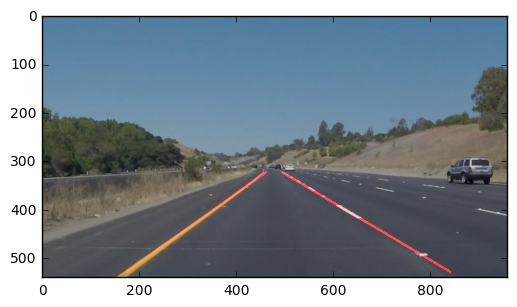

In [8]:
Left_previous = []
Right_previous = []
image = (mpimg.imread('test_images/'+a[2]))
result = process_image(image)
plt.imshow(result)

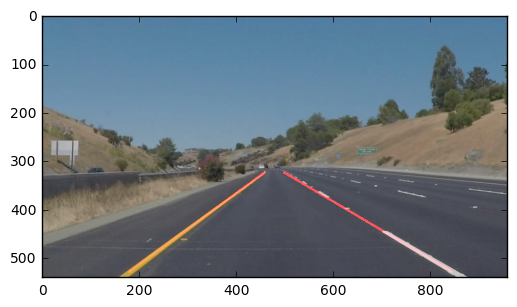

In [9]:
Left_previous = []
Right_previous = []
image = (mpimg.imread('test_images/'+a[3]))
result = process_image(image)
plt.imshow(result)

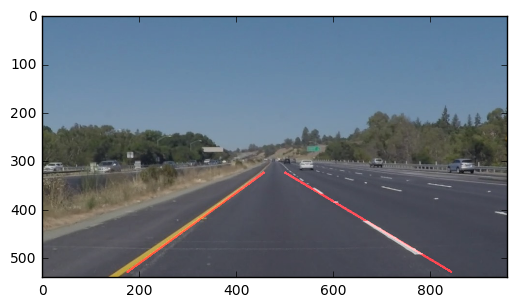

In [10]:
image = (mpimg.imread('test_images/'+a[4]))
result = process_image(image)
plt.imshow(result)

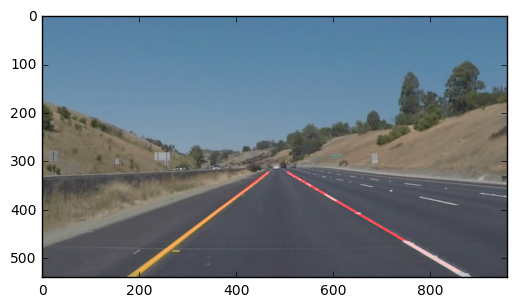

In [11]:
Left_previous = []
Right_previous = []
image = (mpimg.imread('test_images/'+a[5]))
result = process_image(image)
plt.imshow(result)

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [13]:
Left_previous = []
Right_previous = []

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 64.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.24 s, sys: 1.07 s, total: 5.32 s
Wall time: 3.82 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
Left_previous = []
Right_previous = []

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 67.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.8 s, sys: 3.38 s, total: 16.2 s
Wall time: 10.5 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Pipeline Description and the Ideas Behind

My lane detection in this project basically has three modules:

1. color detection
2. line segment detection
3. lane detection

Color detection aims to isolate lane markings hile blacking out irrelevant objects as much as possible.

    1.1 convert BGR to HSV
    1.2 convert the third channel of HSV to gray scale
    1.3 black out all pixels lower than a certain threshold of intensity
    
    My experiments showed that both white and yellow color can be well detected by using the third channel of HSV 
    
Line segment detection aims to find staight lines which are the candicates of lane markings.
    
    2.1 gaussian blur the gray image
    2.2 canny edge
    2.3 hough line detection
    
    It is important to choose a good set of parameters for hough line detection. 
    My experience is: First, a large value of min_gap should be used so that longer line segments can be detected
    Then, starting from a smaller value, gradually increase threshold
    Granularity and max_length are not as important and the two parameters above, a reasonable small granularity and a reasonable large max_length would work.
    
Lane detection aims to find the final lane indication by summarizing and extending all detected line segments.

    3.1 filter by slope
    3.2 group to left and right
    3.3 fit a line based on end points of all line segments in one group
    3.4 extend/truncate the line to certain length
    3.5 smoothing the lane detection in a video using previous frames
    
    When smoothing the lane detection in a video, two parameters matter: 1. a = number of previous frames; 2. b = weight of current frame. Small a and large b would provide faster response to lane loction changes but meanwhile it is also more sensitive to noises. I used 3 previous frames and give the current frame a slightly higher weight than previous frames.

## Limitations

From the experience of dealing with the challenge video below, I found a lot of limiations in my current program.

The most critical one is my program couldn't detect curve. By just detecting strait lines, it is not possible to achieve a good turning maneuver at a high driving speed. I was thinking about something like curve stitching (detect short straight line segments and stitch them into a curve) but I didn't successfully solve it so if you as a review can point me some resource I will be very grateful.

Other limitations are related to fixed parameters. For example, the parameters for hough line detection, the threshold for instensity filtering and the vertices of intreseted area may not be transferable to other videos.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
Left_previous = []
Right_previous = []

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 32.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.73 s, sys: 2.11 s, total: 10.8 s
Wall time: 8.71 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))